# Classifying Headlines into LDA topics

## Imports

In [5]:
import pandas as pd
import numpy as np
import nltk

from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [6]:
total_data = pd.read_parquet("../data/processed/news-consolidated-v2.parquet")
total_data.head()

,id,source,date,headline,embedding,url,sentiment_score,sentiment_label
0,0,abc,2003-02-19,a g calls for infrastructure protection summit,"[0.42550426721572876, 0.5782315135002136, 0.09...",null,0.766538,neutral
1,1,abc,2003-02-19,epa still trying to recover chemical clean up ...,"[0.33238619565963745, -0.3517177700996399, 0.5...",null,0.563630,negative
2,2,abc,2003-02-19,expressions of interest sought to build livestock,"[0.4847770035266876, 0.10000099241733551, -0.0...",null,0.843926,neutral
3,3,abc,2003-02-19,iraq to pay for own rebuilding white house,"[0.4847399592399597, 0.20435450971126556, 0.19...",null,0.762468,neutral
4,4,abc,2003-02-19,meeting to focus on broken hill water woes,"[0.3507457375526428, 0.43837735056877136, -0.0...",null,0.720201,neutral


In [46]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases, CoherenceModel


def preProcessData(dataframe):
    headlines = dataframe["headline"].tolist()

    # Same process as psb-000-mini_LDA.ipynb

    # Tokenize the documents.
    tokenizer = RegexpTokenizer(r"\w+")
    for idx in range(len(headlines)):
        # Remove punctuation and lowercase the documents.
        headlines[idx] = tokenizer.tokenize(headlines[idx])
        headlines[idx] = [w.lower() for w in headlines[idx] if len(w) > 1]

    # Remove stopwords and lemmatize the documents
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()

    for idx in range(len(headlines)):
        headlines[idx] = [w for w in headlines[idx] if not w in stop_words]
        headlines[idx] = [lemmatizer.lemmatize(token) for token in headlines[idx]]

    # Add bigrams
    percent_freq = 0.02

    bigram = Phrases(headlines, min_count=percent_freq * len(headlines))
    for idx in range(len(headlines)):
        for token in bigram[headlines[idx]]:
            if "_" in token:
                # Token is a bigram, add to document.
                headlines[idx].append(token)

    dictionary = Dictionary(headlines)
    corpus = [dictionary.doc2bow(doc) for doc in headlines]

    return dictionary, corpus, headlines

In [15]:
dictionary, corpus, headlines = preProcessData(total_data)
bow_vectors = [dictionary.doc2bow(headline) for headline in headlines]


In [41]:
from gensim import  models
lda = models.ldamodel.LdaModel.load("../data/models/psb-005-LDA_each_V1.model")
topics = lda.get_document_topics(bow_vectors, minimum_probability=0.0)
topics = pd.DataFrame(topics)
topics = topics.apply(lambda x: max(x, key=lambda y: y[1]), axis=1)
topics = pd.DataFrame(topics.tolist(), columns=["topic", "prob"])
total_data["LDA_index"] = topics["topic"]
total_data["LDA_score"] = topics["prob"]

In [71]:
values = lda.show_topics(num_topics=20, num_words=10, formatted=False)
values = pd.DataFrame(values)
values["Summary"] = ["Crisis and Struggle", "Threat and Mitigation", "Drought and Resource Management", "Cost and Resource Management", "Sustainable Development and Environmental Protection", "Economic and Infrastructural Study", "Green Energy and Sustainability", "Oceanic Impact and Weather Condition", "Policy and Benefit Analysis", "Risks and Impacts on Health and Environment", "Environmental/Geographic Issues and Trends", "Water and Environmental Management", "Impact of Life and Industry on Society", "Showcasing Assessment and Early Management", "Air Pollution", "Natinoal Energy Future and Usage", "Impact of Climate Change", "Urban Trade and Warnings", "Human Impact on Environment", "Use of Natural Resources"]
values.head()
values.to_csv("../data/intermediate/LDATopics.csv")

In [65]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [63]:
model_list, coherence_values = compute_coherence_values(dictionary, corpus, headlines, limit=40, start=2, step=6)


TypeError: 'LdaModel' object is not callable

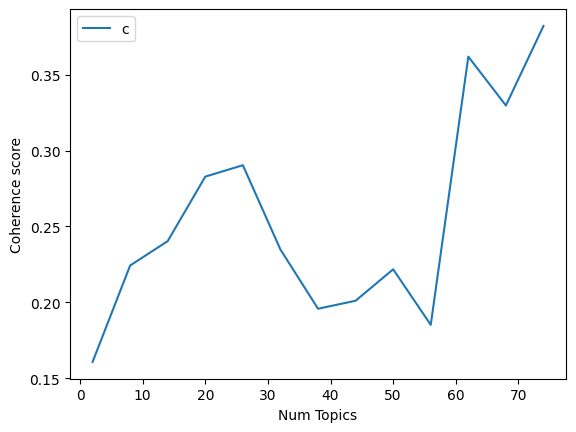

In [61]:
import matplotlib.pyplot as plt
limit=80; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
coherence_model = CoherenceModel(model=lda, texts=headlines, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print("coherence: ", coherence)

coherence:  0.3812996613524041


In [42]:
total_data.to_parquet("../data/processed/news-consolidated-v3.parquet")